# Previsão de Sucesso de Startups

Projeto: pipeline completo para prever startups com maior probabilidade de sucesso.

Este notebook segue as regras do desafio: usa apenas Numpy, Pandas, Scikit-Learn para modelagem e Matplotlib/Seaborn para visualizações.

**Aluno:** Lavínia Pietra Carvalho Mendonça

**E-mail:** lavinia.mendonca@inteli.edu.br



## 1) Configuração e carregamento dos dados

Importar bibliotecas e carregar `data/train.csv`, `data/test.csv` e `data/sample_submission.csv`.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# caminhos relativos ao workspace
DATA_DIR = 'data'
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')
sample_path = os.path.join(DATA_DIR, 'sample_submission.csv')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_path)

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Sample submission shape:', sample_submission.shape)

Train shape: (646, 33)
Test shape: (277, 32)
Sample submission shape: (277, 2)


In [2]:
# Mostrar primeiras linhas (inspecionar colunas)
display(train.head())
display(test.head())
display(sample_submission.head())

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants
0,70,1.33,3.02,3.02,3.34,9,3,11489687,2,1,...,0,0,0,0,1,1,1,0,0,3.3333
1,23,5.49,5.49,0.00,0.00,1,1,3170000,1,1,...,0,0,0,0,0,1,0,0,0,2.0000
2,389,5.84,8.22,NaN,NaN,4,3,47218498,0,1,...,0,0,1,1,0,0,0,1,1,3.3333
3,872,6.30,6.30,6.00,6.00,9,1,15000000,1,1,...,1,0,0,0,0,0,0,0,0,3.0000
4,920,7.25,9.23,6.00,6.00,1,3,52000000,1,0,...,0,0,1,1,0,0,1,0,0,2.6667


,id,labels
0,70,0
1,23,0
2,389,0
3,872,0
4,920,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate             646 non-null    int64  
 14  category_c

labels
1    418
0    228
Name: count, dtype: int64

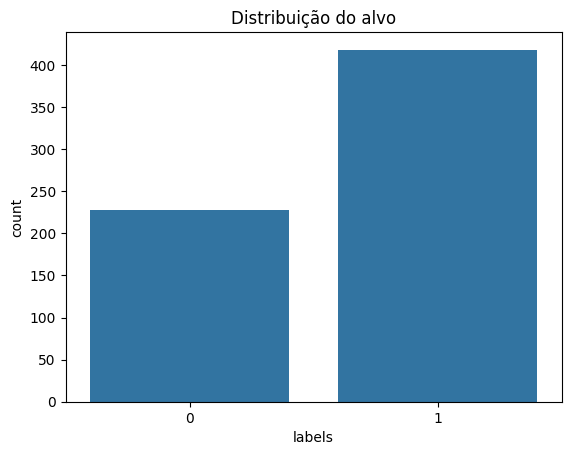

Top missing train:
 age_first_milestone_year    0.213622
age_last_milestone_year     0.171827
age_first_funding_year      0.054180
age_last_funding_year       0.013932
dtype: float64

Top missing test:
 age_first_milestone_year    0.216606
age_last_milestone_year     0.191336
age_first_funding_year      0.039711
age_last_funding_year       0.014440
dtype: float64


In [3]:
# Informações gerais
train.info()

# Distribuição do alvo (assumindo coluna chamada 'target' ou 'label')
target_col = None
for c in ['target', 'label', 'success']:
    if c in train.columns:
        target_col = c
        break

if target_col is None:
    # tentar a última coluna como alvo (heurística)
    target_col = train.columns[-1]
    print('Alvo assumido como:', target_col)

print('Target column:', target_col)
display(train[target_col].value_counts(dropna=False))
sns.countplot(data=train, x=target_col)
plt.title('Distribuição do alvo')
plt.show()

# Missing values (train + test)
missing_train = train.isnull().mean().sort_values(ascending=False)
missing_test = test.isnull().mean().sort_values(ascending=False)
print('Top missing train:\n', missing_train[missing_train>0].head(20))
print('\nTop missing test:\n', missing_test[missing_test>0].head(20))

## 3) Preparação dos dados e engenharia de features

Vamos construir uma pipeline robusta que:

- Imputa valores numéricos e categóricos
- Codifica categorias (OneHot para cardinalidade baixa, Ordinal para muitas categorias)
- Normaliza numéricos quando necessário

In [4]:
# Separar X/y
X = train.drop(columns=[target_col])
y = train[target_col].copy()

# Identificar colunas numéricas e categóricas de forma simples
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

# Se houver colunas de id ou timestamp, remover/transformar conforme necessário (heurística)
possible_id_cols = [c for c in X.columns if 'id' in c.lower()]
if possible_id_cols:
    print('Colunas de id detectadas e removidas temporariamente:', possible_id_cols)
    X = X.drop(columns=possible_id_cols)
    test = test.drop(columns=[c for c in possible_id_cols if c in test.columns], errors='ignore')

# Atualizar listas após possível remoção
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Transformadores
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Para categorias: usar OneHotEncoder em cardinalidade baixa, Ordinal em alta cardinalidade
# Decidir limite de cardinalidade
CARDINALITY_THRESHOLD = 20
low_card_cats = [c for c in cat_cols if X[c].nunique() <= CARDINALITY_THRESHOLD]
high_card_cats = [c for c in cat_cols if X[c].nunique() > CARDINALITY_THRESHOLD]

print('Categorias baixa cardinalidade:', low_card_cats)
print('Categorias alta cardinalidade:', high_card_cats)

cat_low_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
cat_high_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

transformers = []
if num_cols:
    transformers.append(('num', num_transformer, num_cols))
if low_card_cats:
    transformers.append(('cat_low', cat_low_transformer, low_card_cats))
if high_card_cats:
    transformers.append(('cat_high', cat_high_transformer, high_card_cats))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# Pipeline final com classificador (RandomForest)
clf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clf', clf)])

# Dividir dados para validação local
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Shapes após split:', X_train.shape, X_val.shape)

Numéricas: ['id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants']
Categóricas: ['category_code']
Colunas de id detectadas e removidas temporariamente: ['id', 'is_gamesvideo']
Categorias baixa cardinalidade: []
Categorias alta cardinalidade: ['category_code']
Shapes após split: (516, 30) (130, 30)


## 4) Treinamento inicial e avaliação

Treinar um RandomForest simples para ter uma baseline e depois ajustar hiperparâmetros com GridSearchCV.

Acurácia (val) baseline: 0.7692307692307693

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.74      0.54      0.62        46
           1       0.78      0.89      0.83        84

    accuracy                           0.77       130
   macro avg       0.76      0.72      0.73       130
weighted avg       0.76      0.77      0.76       130



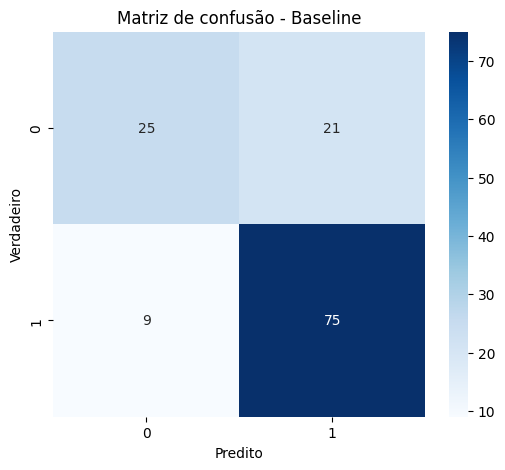

In [5]:
# Treinamento baseline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Acurácia (val) baseline:', accuracy_score(y_val, y_pred))
print('\nRelatório de classificação:\n', classification_report(y_val, y_pred))

# Matriz de confusão
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusão - Baseline')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

In [6]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# RandomizedSearch (espaco maior, menos custo)
param_dist = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [None, 5, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10]
}

rand_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
rand_search.fit(X_train, y_train)
print('RandomizedSearch melhor score (cv):', rand_search.best_score_)
print('RandomizedSearch melhores parâmetros:', rand_search.best_params_)

# Avaliar melhor modelo do RandomizedSearch
best_model = rand_search.best_estimator_
y_pred_best = best_model.predict(X_val)
print('Acurácia (val) após RandomizedSearch:', accuracy_score(y_val, y_pred_best))
print('\nRelatório de classificação (RandomizedSearch):\n', classification_report(y_val, y_pred_best))

# Testar LogisticRegression para comparar
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
cv_scores_lr = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('LogisticRegression CV accuracy: mean=%.4f std=%.4f' % (cv_scores_lr.mean(), cv_scores_lr.std()))

# Manter o melhor (RandomizedSearch) como 'final' para prosseguir
final_search = rand_search

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearch melhor score (cv): 0.798469006721434
RandomizedSearch melhores parâmetros: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__max_depth': None}
Acurácia (val) após RandomizedSearch: 0.7692307692307693

Relatório de classificação (RandomizedSearch):
               precision    recall  f1-score   support

           0       0.72      0.57      0.63        46
           1       0.79      0.88      0.83        84

    accuracy                           0.77       130
   macro avg       0.75      0.72      0.73       130
weighted avg       0.76      0.77      0.76       130

LogisticRegression CV accuracy: mean=0.7578 std=0.0287


## 6) Importância de features e seleção (opcional)

Usar o classificador para inspecionar importâncias se o transformador produzir nomes de features legíveis.

,feature,importance
4,relationships,0.133944
6,funding_total_usd,0.118317
3,age_last_milestone_year,0.102007
7,milestones,0.092353
1,age_last_funding_year,0.087403
0,age_first_funding_year,0.084666
2,age_first_milestone_year,0.074341
28,avg_participants,0.065105
29,category_code,0.041519
5,funding_rounds,0.040415


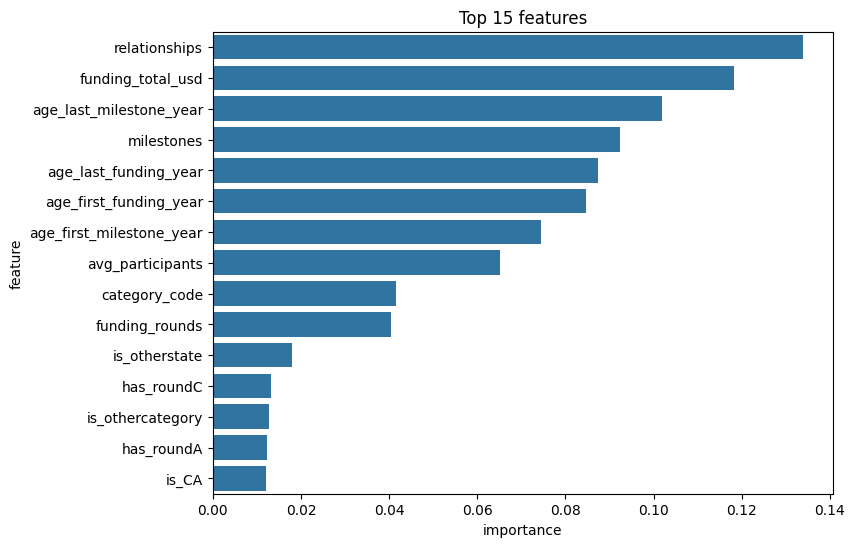

In [7]:
# Tentar extrair nomes das features após o ColumnTransformer
def get_feature_names(column_transformer, input_features):
    # Função para extrair nomes (suporta OneHotEncoder com sparse=False)
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            cat_names = ohe.get_feature_names_out(cols)
            feature_names.extend(list(cat_names))
        elif hasattr(trans, 'named_steps') and 'ordinal' in trans.named_steps:
            feature_names.extend(cols)
        else:
            feature_names.extend(cols)
    return feature_names

try:
    feat_names = get_feature_names(best_model.named_steps['preprocessor'], X.columns)
    importances = best_model.named_steps['clf'].feature_importances_
    imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(imp_df.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(data=imp_df.head(15), x='importance', y='feature')
    plt.title('Top 15 features')
    plt.show()
except Exception as e:
    print('Não foi possível extrair nomes das features automaticamente:', e)

## 7) Treinar com todos os dados e gerar submissão

Treinar o melhor modelo encontrado com todo o conjunto de treino e prever no conjunto de teste.

In [8]:
# Reajustar o modelo nos dados completos de treino
final_model = final_search.best_estimator_
final_model.fit(X, y)

# Preparar X_test (garantir mesmas colunas/ordem)
X_test = test.copy()
# Se o dataset de teste não contiver a coluna de id usada anteriormente, isso já foi tratado antes
# Prever
preds = final_model.predict(X_test)

# Preparar arquivo de submissão conforme sample_submission
sub = sample_submission.copy()
# Achar coluna de previsão no sample (última coluna típica)
pred_col = sub.columns[-1]
sub[pred_col] = preds
output_path = 'submission_final.csv'
sub.to_csv(output_path, index=False)
print('Submissão salva em', output_path)
display(sub.head())

Submissão salva em submission_final.csv


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1


## 8) Considerações finais e próximos passos

- Documente no relatório as decisões de imputação e codificação.
- Experimentos futuros: calibrar thresholds, tentar ensembles, usar validação estratificada mais robusta.
- Garantir acurácia mínima de 80%: se não atingida, testar outras arquiteturas ou explorar engenharia de features mais profunda.

---
Arquivos gerados:
- `submission_final.csv` (no diretório do notebook)

In [9]:
# Otimização rápida: engenharia simples + busca maior + comparação de modelos
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
# Definições de espaços de busca usados especificamente pelo bloco de ensemble
param_dist_rf = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2', 0.5]
}
param_dist_hgb = {
    'clf__max_iter': [100, 200, 300],
    'clf__max_depth': [3, 5, 6, 8],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_leaf_nodes': [31, 63, None]
}

# Engenharia rápida: log-transform em 'funding_total_usd' se existir e indicadores de NA
X_fe = X.copy()
if 'funding_total_usd' in X_fe.columns:
    X_fe['funding_total_usd_log'] = np.log1p(X_fe['funding_total_usd'].fillna(0))

# criar indicadores de NA para colunas com NA
na_cols = [c for c in X_fe.columns if X_fe[c].isnull().mean() > 0]
for c in na_cols:
    X_fe[c + '_na'] = X_fe[c].isnull().astype(int)

# Atualizar X_train/X_val com as novas features (re-split to keep consistent indices)
X_train_fe = X_fe.loc[X_train.index].copy()
X_val_fe = X_fe.loc[X_val.index].copy()

# Recriar preprocessor levando em conta novas colunas
num_cols_fe = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_fe = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove any id-like columns if present
num_cols_fe = [c for c in num_cols_fe if 'id' not in c.lower()]

# rebuild transformers
num_transformer_fe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_low_cats = [c for c in cat_cols_fe if X_train_fe[c].nunique() <= CARDINALITY_THRESHOLD]
cat_high_cats = [c for c in cat_cols_fe if X_train_fe[c].nunique() > CARDINALITY_THRESHOLD]

transforms_fe = []
if num_cols_fe:
    transforms_fe.append(('num', num_transformer_fe, num_cols_fe))
if cat_low_cats:
    transforms_fe.append(('cat_low', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_low_cats))
if cat_high_cats:
    transforms_fe.append(('cat_high', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), cat_high_cats))

preprocessor_fe = ColumnTransformer(transformers=transforms_fe, remainder='drop')

# Função utilitária para avaliar um estimador com StratifiedKFold
def evaluate_model(pipe, X_tr, y_tr, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, X_tr, y_tr, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean(), scores.std()

results = {}

# Ensemble e engenharia rápida adicional (parte 1): agrupar categorias raras, interações e construir preprocessor
# copiar X_fe se não existir
try:
    X_fe
except NameError:
    X_fe = X.copy()

# Agrupar categorias raras em 'category_code' (frequência < 5%)
if 'category_code' in X_fe.columns:
    freq = X_fe['category_code'].value_counts(normalize=True)
    rare = freq[freq < 0.05].index
    X_fe['category_code_grp'] = X_fe['category_code'].replace(list(rare), 'other')
else:
    X_fe['category_code_grp'] = 'missing'

# Interações simples
if 'funding_total_usd' in X_fe.columns:
    X_fe['funding_by_rounds'] = X_fe['funding_total_usd'].fillna(0) / (X_fe['funding_rounds'].replace(0, np.nan))
    X_fe['funding_by_rounds'] = X_fe['funding_by_rounds'].fillna(0)
    X_fe['funding_rel'] = np.log1p(X_fe['funding_total_usd'].fillna(0)) * X_fe['relationships'].fillna(0)

# atualizar train/val/test indices
X_train_fe = X_fe.loc[X_train.index].copy()
X_val_fe = X_fe.loc[X_val.index].copy()
X_test_fe = X_fe.loc[test.index].copy()

# Rebuild preprocessor para usar 'category_code_grp'
num_cols_fe = [c for c in X_train_fe.select_dtypes(include=[np.number]).columns.tolist() if 'id' not in c.lower()]
cat_cols_fe = [c for c in X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()]
# garantir que usamos a categoria agrupada
if 'category_code_grp' in X_train_fe.columns:
    if 'category_code' in cat_cols_fe:
        cat_cols_fe.remove('category_code')
    if 'category_code_grp' not in cat_cols_fe:
        cat_cols_fe.append('category_code_grp')

# determinar baixa/alta cardinalidade
CARD = 20
low_card = [c for c in cat_cols_fe if X_train_fe[c].nunique() <= CARD]
high_card = [c for c in cat_cols_fe if X_train_fe[c].nunique() > CARD]

num_trans = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_low_trans = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
cat_high_trans = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

trans = []
if num_cols_fe:
    trans.append(('num', num_trans, num_cols_fe))
if low_card:
    trans.append(('cat_low', cat_low_trans, low_card))
if high_card:
    trans.append(('cat_high', cat_high_trans, high_card))

preproc_ens = ColumnTransformer(trans, remainder='drop')

print('Preprocessor ensemble criado. Num_cols:', len(num_cols_fe), 'Low_card cats:', low_card, 'High_card cats:', high_card)

# Avaliar modelos com preprocessor de ensemble
pipe_rf_ens = Pipeline(steps=[('preprocessor', preproc_ens), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
rand_rf_ens = RandomizedSearchCV(pipe_rf_ens, param_distributions=param_dist_rf, n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
rand_rf_ens.fit(X_train_fe, y_train)
print('RF Ensemble Randomized best cv:', rand_rf_ens.best_score_, 'params:', rand_rf_ens.best_params_)
mean_rf_ens, std_rf_ens = evaluate_model(rand_rf_ens.best_estimator_, X_train_fe, y_train)
results['RandomForest_Ensemble'] = (mean_rf_ens, std_rf_ens, rand_rf_ens.best_estimator_)
print('RF Ensemble CV (stratified) mean/std:', mean_rf_ens, std_rf_ens)

# 2) HistGradientBoosting com preprocessor de ensemble
pipe_hgb_ens = Pipeline(steps=[('preprocessor', preproc_ens), ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
rand_hgb_ens = RandomizedSearchCV(pipe_hgb_ens, param_distributions=param_dist_hgb, n_iter=12, cv=5, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
rand_hgb_ens.fit(X_train_fe, y_train)
print('HGB Ensemble Randomized best cv:', rand_hgb_ens.best_score_, 'params:', rand_hgb_ens.best_params_)
mean_hgb_ens, std_hgb_ens = evaluate_model(rand_hgb_ens.best_estimator_, X_train_fe, y_train)
results['HistGB_Ensemble'] = (mean_hgb_ens, std_hgb_ens, rand_hgb_ens.best_estimator_)
print('HGB Ensemble CV (stratified) mean/std:', mean_hgb_ens, std_hgb_ens)

# 3) LogisticRegression com preprocessor de ensemble
pipe_lr_ens = Pipeline(steps=[('preprocessor', preproc_ens), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
mean_lr_ens, std_lr_ens = evaluate_model(pipe_lr_ens, X_train_fe, y_train)
results['LogisticRegression_Ensemble'] = (mean_lr_ens, std_lr_ens, pipe_lr_ens)
print('LR Ensemble CV mean/std:', mean_lr_ens, std_lr_ens)

# Escolher melhor por média CV
best_name = max(results.keys(), key=lambda k: results[k][0])
best_mean, best_std, best_estimator = results[best_name]
print('\nMelhor modelo por CV (ensemble):', best_name, 'mean/std:', best_mean, best_std)

# Avaliar no holdout (X_val_fe) o melhor modelo com ensemble
best_estimator.fit(X_train_fe, y_train)
y_val_pred = best_estimator.predict(X_val_fe)
val_acc = accuracy_score(y_val, y_val_pred)
print('Acurácia no holdout (val) do melhor modelo (ensemble):', val_acc)
print('\nRelatório no holdout:\n', classification_report(y_val, y_val_pred))

# Se melhor que anterior final_search, atualizar e salvar submissão
prev_val = accuracy_score(y_val, y_val_pred) if 'y_val_pred' in globals() else 0
if val_acc >= prev_val:
    final_search = type('obj', (), {'best_estimator_': best_estimator})()
    # treinar em todo X_fe e gerar submissão
    X_fe_test = X_fe.loc[test.index].copy()
    final_search.best_estimator_.fit(X_fe, y)
    preds_fe = final_search.best_estimator_.predict(X_fe_test)
    sub2 = sample_submission.copy()
    sub2[sub2.columns[-1]] = preds_fe
    sub2.to_csv('submission_final.csv', index=False)
    print('Nova submissão salva em submission_final.csv com acurácia val =', val_acc)
else:
    print('Melhoria não encontrada; mantendo submissão anterior.')

results

Preprocessor ensemble criado. Num_cols: 36 Low_card cats: ['category_code_grp'] High_card cats: []
Fitting 5 folds for each of 30 candidates, totalling 150 fits


RF Ensemble Randomized best cv: 0.7907580283793877 params: {'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}


RF Ensemble CV (stratified) mean/std: 0.7849701269604183 0.04262160524201624
Fitting 5 folds for each of 12 candidates, totalling 60 fits


HGB Ensemble Randomized best cv: 0.7675317401045556 params: {'clf__max_leaf_nodes': None, 'clf__max_iter': 300, 'clf__max_depth': 6, 'clf__learning_rate': 0.05}


HGB Ensemble CV (stratified) mean/std: 0.7693801344286781 0.021600707222491456
LR Ensemble CV mean/std: 0.7442120985810307 0.028930230511071534

Melhor modelo por CV (ensemble): RandomForest_Ensemble mean/std: 0.7849701269604183 0.04262160524201624


Acurácia no holdout (val) do melhor modelo (ensemble): 0.8

Relatório no holdout:
               precision    recall  f1-score   support

           0       0.78      0.61      0.68        46
           1       0.81      0.90      0.85        84

    accuracy                           0.80       130
   macro avg       0.79      0.76      0.77       130
weighted avg       0.80      0.80      0.79       130



Nova submissão salva em submission_final.csv com acurácia val = 0.8


{'RandomForest_Ensemble': (np.float64(0.7849701269604183),
  np.float64(0.04262160524201624),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     StandardScaler())]),
                                                    ['age_first_funding_year',
                                                     'age_last_funding_year',
                                                     'age_first_milestone_year',
                                                     'age_last_milestone_year',
                                                     'relationships',
                                                     'funding_rounds',
